In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import warnings

# Ignore a bunch of Arviz/pymc3 deprecated warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_FOLDER = '../../data'
RUGGED_DATA = 'rugged.csv'

In [3]:
df = pd.read_csv(f'{DATA_FOLDER}/{RUGGED_DATA}')
df.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


In [4]:
df.isna().any()

isocode                   False
isonum                    False
country                   False
rugged                    False
rugged_popw               False
rugged_slope              False
rugged_lsd                False
rugged_pc                 False
land_area                  True
lat                       False
lon                       False
soil                       True
desert                    False
tropical                  False
dist_coast                False
near_coast                False
gemstones                 False
rgdppc_2000                True
rgdppc_1950_m              True
rgdppc_1975_m              True
rgdppc_2000_m              True
rgdppc_1950_2000_m         True
q_rule_law                 True
cont_africa               False
cont_asia                 False
cont_europe               False
cont_oceania              False
cont_north_america        False
cont_south_america        False
legor_gbr                  True
legor_fra                  True
legor_so

## Data Prep

### Code 9.11

In [5]:
# extract countries with GDP data
df_gdp = df[df['rgdppc_2000'].notna()].copy()

In [6]:
df_gdp[['rgdppc_2000', 'rugged']].describe()

,rgdppc_2000,rugged
count,170.000000,170.000000
mean,9094.892853,1.333182
std,9699.991472,1.168467
min,466.647000,0.003000
25%,1880.829250,0.442250
50%,5314.742000,0.979500
75%,13100.150000,1.957250
max,57792.090000,6.202000


In [7]:
df_gdp['cont_africa'].unique()

array([1, 0])

In [8]:
# log transform variables 
df_gdp['log_gdp'] = np.log(df_gdp['rgdppc_2000'].values)

# rescale vars: Note that for 'rugged' we are using min-max scaling
df_gdp['log_gdp_std'] = df_gdp['log_gdp'] / np.mean(df_gdp['log_gdp'])
df_gdp['rugged_std'] = (df_gdp['rugged'] - np.min(df_gdp['rugged'])) / ( np.max(df_gdp['rugged']) - np.min(df_gdp['rugged']))

cid = pd.Categorical(df_gdp['cont_africa'])
mean_rugged = np.mean(df_gdp['rugged_std'])

df_gdp_slim = df_gdp[['rugged_std', 'log_gdp_std']].copy()

In [9]:
cid.categories.size

2

### Code 9.12

In [10]:
with pm.Model() as m_8_3:
    a = pm.Normal('a', mu=1, sigma=0.1, shape=cid.categories.size)
    b = pm.Normal('b', mu=0, sigma=0.3, shape=cid.categories.size)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = a[cid] + b[cid] * (df_gdp_slim['rugged_std'] - mean_rugged)
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sigma=sigma, observed=df_gdp_slim['log_gdp_std'])
    
    trace_8_3 = pm.sample(1000, tune=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 9 seconds.


In [11]:
az.summary(trace_8_3, var_names=['a', 'b', 'sigma'], hdi_prob=0.89, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.05,0.01,1.03,1.07,0.0,0.0,7024.55,3127.39,1.0
a[1],0.89,0.02,0.86,0.91,0.0,0.0,6240.49,3416.46,1.0
b[0],-0.14,0.06,-0.23,-0.06,0.0,0.0,7362.41,3103.45,1.0
b[1],0.13,0.08,0.01,0.26,0.0,0.0,5815.87,3159.93,1.0
sigma,0.11,0.01,0.10,0.12,0.0,0.0,7298.02,2930.71,1.0


## Visualization

### Figure 9.7

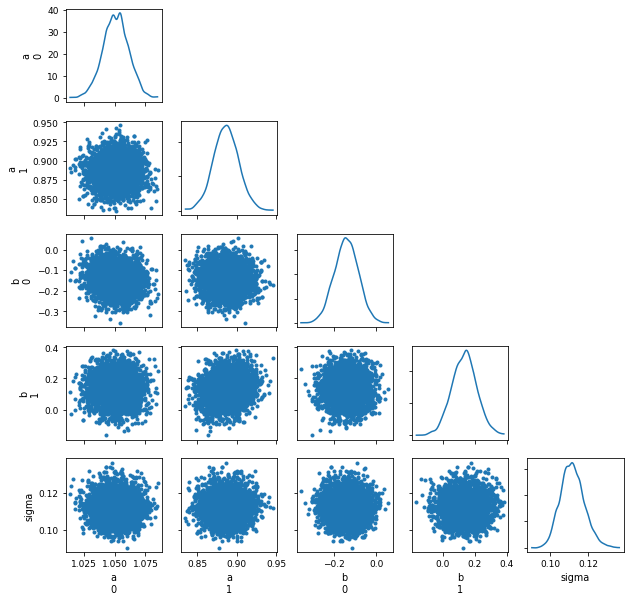

In [12]:
az.plot_pair(trace_8_3, var_names=['a', 'b', 'sigma'], figsize=[10, 10], marginals=True, textsize=9);

## Figure 9.8 (Top)

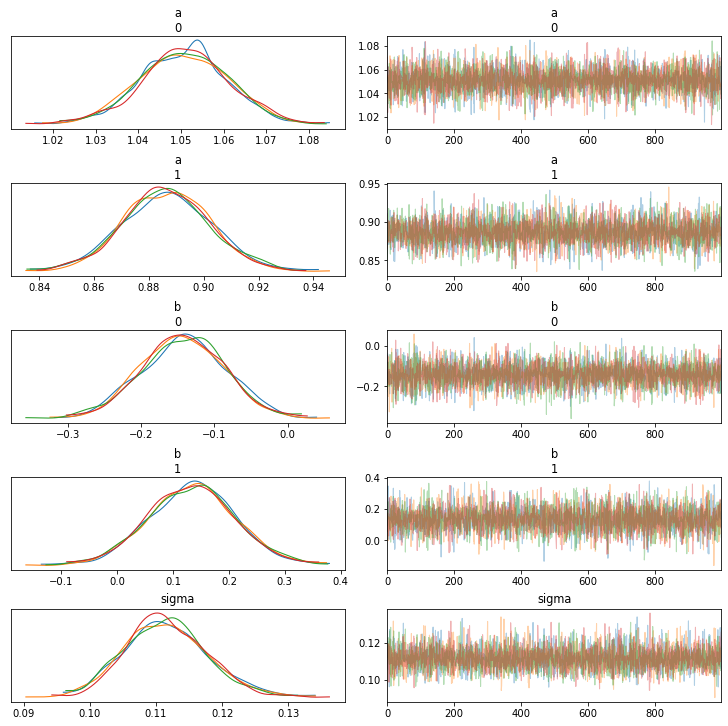

In [13]:
az.plot_trace(trace_8_3, figsize=[10, 10], compact=False);

## Figure 9.8 (Bottom)

In the rank plots, one first ranks all the samples from _all_ the chains. In this example, there are four chains with $500$ samples per chain making it a total of $2000$ samples for any given parameter. The smallest sample gets rank $1$ and the largest sample gets rank $2000$. The horizontal axis depicts the ranks. The vertical axis depicts the frequencies of these ranks across all the four chains. 

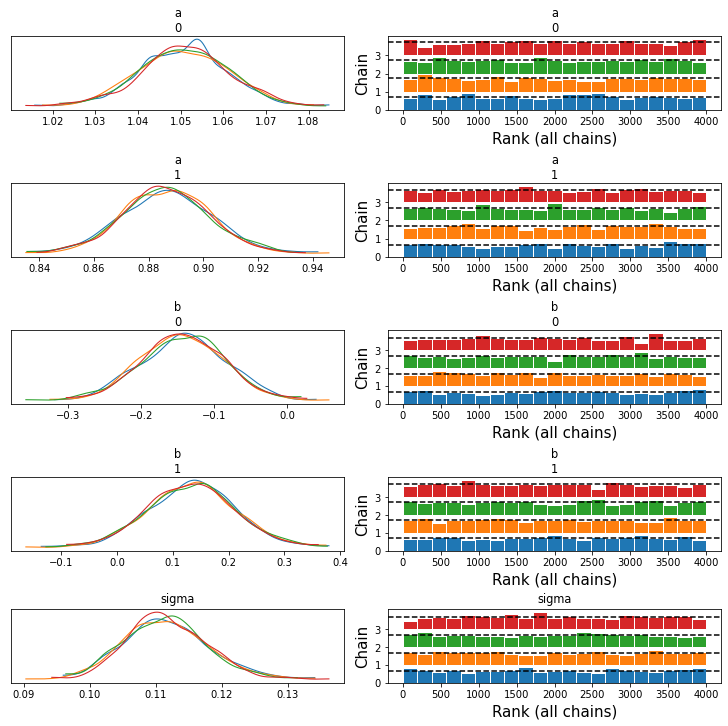

In [14]:
az.plot_trace(trace_8_3, figsize=[10, 10], compact=False, kind='rank_bars');

In [15]:
model_8_3_dataset = az.convert_to_dataset(trace_8_3)
model_8_3_dataset

<xarray.Dataset>
Dimensions:  (a_dim_0: 2, b_dim_0: 2, chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * a_dim_0  (a_dim_0) int64 0 1
  * b_dim_0  (b_dim_0) int64 0 1
Data variables:
    a        (chain, draw, a_dim_0) float64 1.054 0.9113 1.049 ... 1.045 0.8713
    b        (chain, draw, b_dim_0) float64 -0.2116 0.1251 ... -0.1147 0.1033
    sigma    (chain, draw) float64 0.1053 0.1209 0.1127 ... 0.1098 0.1226 0.1258
Attributes:
    created_at:                 2021-04-21T05:49:18.263052
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              8.847082376480103
    tuning_steps:               2000

## Sample Size

(See also https://stats.stackexchange.com/questions/296059/effective-sample-size-greater-than-actual-sample-size)

What matters is the _effective sample size_. This is an estimate of the number of independent samples from the posterior distribution. Markov chains are typically autocorrelated so that sequential samples are not independent. The _effective sample size of an estimator_ compares the variance of that estimator assuming that the samples were drawn independently to the variance of the estimator with the samples actually obtained. The ess is defined as:
$$
    \text{ess of estimator} = \text{number of samples} \cdot 
                \frac{\text{variance of estimator assuming samples were obtained by independent draws}}
                     {\text{variance of estimator with samples actually obtained}}
$$

Consider samples $X_1, \ldots, X_n$ obtained from a distribution with mean $\mu$ and variance $\lambda^2$. Suppose that we use the sample mean to estimate $\mu$. If the samples had been independent, then $\text{Var}(\bar{X}_n) = \lambda^2 / n$. But if they were correlated then
$$
\begin{align*}
    \text{Var}(\bar{X}_n) & = \frac{1}{n^2} \cdot \left [ \sum_{i = 1}^n \text{Var}(X_i) 
                                + 2 \cdot \sum_{1 \leq i < j \leq n} \text{Cov} (X_i, X_j) \right ] \\
                          & = \frac{1}{n^2} \cdot \left [ n \lambda^2 
                                + 2 \cdot \sum_{1 \leq i < j \leq n} \text{Cov} (X_i, X_j) \right ] \\
                          & = \frac{\sigma^2}{n},
\end{align*}
$$
where $\sigma^2 = \lambda^2  + (2/n) \cdot \sum_{1 \leq i < j \leq n} \text{Cov} (X_i, X_j)$.

The ess of the estimator $\bar{X}_n$ is then 
$$
    \text{ess} = n \cdot \frac{\lambda^2 / n}{\sigma^2 / n} = n \cdot \frac{\lambda^2}{\sigma^2}.
$$
If $\sigma^2 < \lambda^2$, then the effective number of samples is greater than the actual number of samples; if $\sigma^2 \geq \lambda^2$, then the effective number of samples is at most the actual number of samples.

In [16]:
az.ess(model_8_3_dataset, method='tail', prob=0.95)

<xarray.Dataset>
Dimensions:  (a_dim_0: 2, b_dim_0: 2)
Coordinates:
  * a_dim_0  (a_dim_0) int64 0 1
  * b_dim_0  (b_dim_0) int64 0 1
Data variables:
    a        (a_dim_0) float64 3.127e+03 3.416e+03
    b        (b_dim_0) float64 3.103e+03 3.16e+03
    sigma    float64 2.931e+03